# Posterior predictive tests

When we refer back to the 5.1 pre-class work on the eczema medical trial dataset, we explored both a hierachichal model and a non-hierachichal model. From the class we concluded that the hierachichal model models the _control group_ best while the non-hierachichal model outperforms the other model on the _treatment group_. 

The hierachichal model assumes that the probability of success is equal in all the 6 trials, while the non-hierachical model assumes that they are different.

One of the possible reasons we gave were that, in the treatment group, the treatment is actually working. Therefore, the participants have converging probabilities of success (getting treated). However, in the control group, confounding variables lead to different probabilities of success. An analogy is that of the 2020 coronovirus pandemic. Different geographies as a confounding variable may lead to varying recovery rates, however, after the onset of the vaccine, recovery rates begun converging towards certain values depending on the administered vaccine.

In this writing we evaluate more on why the non-hierachichal model does not explain the control data well.

As a reminder, for each group (treatment and control), all 6 studies have the same fixed, but unknown, probability of success, $\theta_t,\theta_c\in[0,1]$.

The data follows a binomial distribution in each study, conditioned on the probability of success — $\theta_t$ for treatment or $\theta_c$ for control.

These assumptions lead to the following model.

* **Likelihood**: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients.

* **Prior**: $\text{Beta}(\theta\,|\,1,1)$ for both $\theta_t$ and $\theta_c$.

* **Posterior for treatment group**: $\text{Beta}(\theta_t\,|\,108, 35)$.

* **Posterior for control group**: $\text{Beta}(\theta_c\,|\,58, 65)$.

We use standard deviation as our test statistic of choice. Generating posterior probabiities of success, then using them to generate sample data. We then find the standard deviation of the generated data and compare it to the original standard deviation. As expected we get a p-value of $0.0081$ on the original test statistic on the generated data. That tells us that it is highly improbable to see the actual standard deviation from the model's data. Therefore, it doesn't model the situation well.

![non-hierachichal control std](non-hierachical_control_std.png)

In comparison, on the treatment data, the one we mentioned the non-hierachichal model does well in, we find the p-value not being significant (0.5463). Meaning it is within the thresholds and that it is probable to observe the true data if the non-hierachical model was the underlying model.

![non hierachichal treatement std](non-hierachical_treatment_std.png)

## Appendix

### Appendix 1 - Eczema medical trial data set

|Study          | Treatment group |   Control group  |
|---------------|-----------------|------------------|
|Di Rienzo 2014 |     20 / 23     |        9 / 15    |
|Galli 1994     |     10 / 16     |       11 / 18    |
|Kaufman 1974   |     13 / 16     |        4 / 10    |
|Qin 2014       |     35 / 45     |       21 / 39    |
|Sanchez 2012   |     22 / 31     |       12 / 29    |
|Silny 2006     |      7 / 10     |        0 / 10    |
|**Totals**     |    107 / 141    |       57 / 121   |

### Appendix 2 - Imports and data preparation

In [1]:
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data
data_treatment = np.array([
    [20, 10, 13, 35, 22, 7],  # Sucesses
    [3, 6, 3, 10, 9, 3]       # Failures
])

data_control = np.array([
    [9, 11, 4, 21, 12, 0],    # Sucesses
    [6, 7, 6, 18, 17, 10]     # Failures
])

### Appendix 3 - Sampling function

In [3]:
def gen_samples(
    a:int, b:int, orig_data=data_control, sample_size:int=10_000,
) -> np.array:
    """
    Generates samples of the counts of successes
    
    :param a: The alpha parameter in the posterior beta distribution
    :param b: The beta parameter in the posterior beta distribution
    :param orig_data: The original data containing the success and failure counts
    :param sample_size: The number of samples to generate
    
    :returns the generated data samples from the model
    """
    totals: np.array = orig_data[0]+orig_data[1]
    
    # Generate posterior probabilities of success
    model = beta(a, b)
    p_samples: np.array = model.rvs(size=sample_size)
        
    # Generate the data based on the theta values calculated
    samples = binom.rvs(totals, p_samples.reshape(-1, 1))
    return samples

### Appendix 4 - Test statistic and Plotting function

In [4]:
def test_plot(
    a: int, b: int, orig_data: np.array = data_control, 
    sample_size:int=10_000, func=np.std
):
    """
    Generates a plot of a test statistic applied on generated data from
    the model
    
    :param a: The alpha parameter in the posterior beta distribution
    :param b: The beta parameter in the posterior beta distribution
    :param sample_size: The number of samples to generate
    :param orig_data: The original data containing the success and failure counts
    
    :param func: The test statistic function to apply
    """
    samples: np.array = gen_samples(a=a, b=b, sample_size=sample_size, orig_data=orig_data)
    totals: np.array = orig_data[0] + orig_data[1]
    test_statistic_data: np.array = func(samples/totals, axis=1)
    original_test_statistic = func(orig_data[0]/totals)
    
    thresholds: np.array = np.percentile(test_statistic_data, [5, 95])
    
    plt.hist(
        test_statistic_data, 
        alpha=0.5, 
        bins=100
    )
    plt.axvline(
        original_test_statistic, 
        color='red', 
        label="Orginal Test statistic",
        linewidth=5
    )
    plt.xlabel(f'Test statistic of success rate [{func.__name__}]')
    plt.ylabel('Frequency')
    plt.title(
        f'Test statistic distribution of model generated data (p-value = {np.mean(test_statistic_data>original_test_statistic)})'
    )
    
    plt.axvline(thresholds[0], label="p-value thresholds")
    plt.axvline(thresholds[1])
    plt.legend()

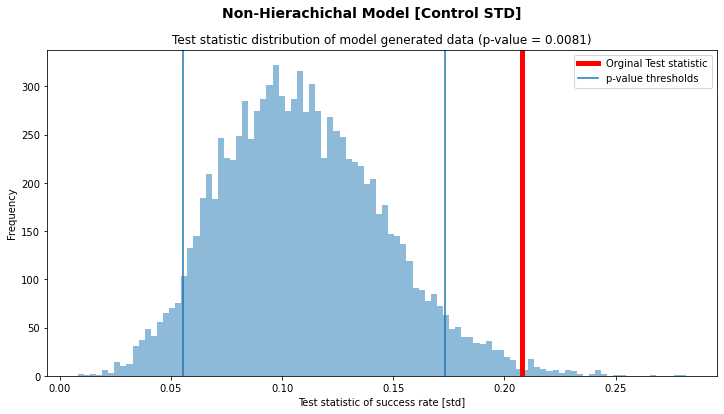

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
fig.suptitle('Non-Hierachichal Model [Control STD]', fontsize=14, fontweight='bold')
test_plot(58, 65)
plt.savefig('non-hierachical_control_std.png')

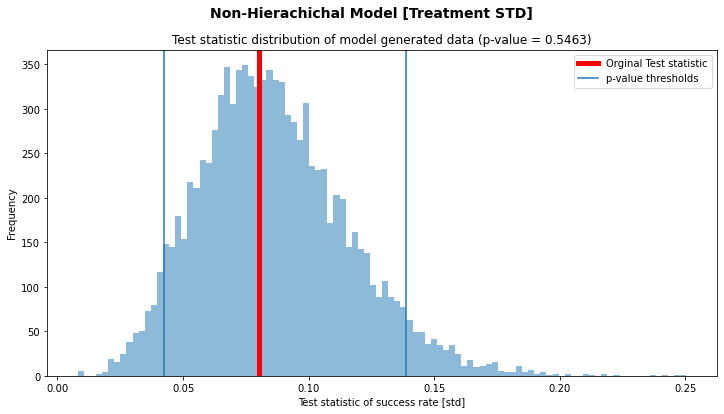

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
fig.suptitle('Non-Hierachichal Model [Treatment STD]', fontsize=14, fontweight='bold')
test_plot(108, 35, orig_data=data_treatment)
plt.savefig('non-hierachical_treatment_std.png')

#### Appendix 4.1 - Additional test statistic

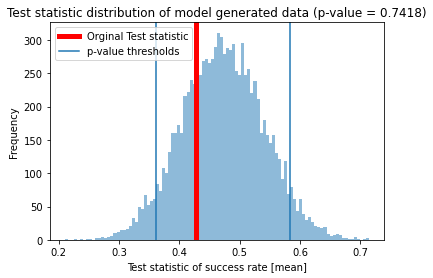

In [7]:
# Control group model with a mean test statistic
test_plot(58, 65, func=np.mean)

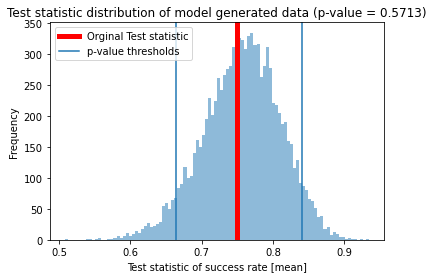

In [8]:
# Treated model with a mean test statistic
test_plot(108, 35, orig_data=data_treatment,func=np.mean)